# **Part Nº 1**

### **1.1 Install Dependencies**

In [7]:
# %pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

### **1.2 Import Dependencies**

In [1]:
import os
import cv2
import numpy as np 
from matplotlib import pyplot as plt
from datetime import datetime

In [2]:
#Import tensorflow API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

2022-12-01 19:26:10.846666: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gabriel/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-01 19:26:10.846717: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### **1.3 Set GPU Growth**

In [3]:
#Avoid OOM errors by setting GPU Memory Consumption Grotwh
#Accessing all GPUs devices
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

# Freeing up memory growth
for gpu in gpus:
  print(gpu)
  tf.config.experimental.set_memory_growth(gpu, True)

[]


2022-12-01 19:26:16.074230: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 19:26:16.086118: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-01 19:26:16.131887: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-01 19:26:16.131921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jarvis): /proc/driver/nvidia/version does not exist


### **1.4 Create Folder Structures**

In [4]:
#Setup paths
## 3 base folders: anchor (images of people that we want to recognize), positive (images of people that we want to recognize) and negative (ima
APP_PATH = '/home/gabriel/Documentos/mestrado/am/notebooks/face-recognition-app'
POS_PATH = os.path.join(APP_PATH, 'data', 'positive')
NEG_PATH = os.path.join(APP_PATH, 'data', 'negative')
ANC_PATH = os.path.join(APP_PATH, 'data', 'anchor')

In [5]:
# Creating directorys
dirnames = [POS_PATH, NEG_PATH, ANC_PATH]
for dir in dirnames:
  if(not os.path.exists(dir)):
    print('Creating directory: ', dir)
    os.makedirs(dir)

# **Part Nº 2**

## **2. Collect Positives and Anchors**

### **2.1 Untar Labelled Faces int the Wild Dataset**

#### **1.   Acess http://vis-www.cs.umass.edu/lfw/**
#### **2.   At the menu, go to Download option**
#### **3.   Download database option 'All images as gzipped tar file'** 

In [13]:
# http://vis-www.cs.umass.edu/lfw/
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
TGZ_PATH = os.path.join(APP_PATH, 'lfw.tgz')
# Uncomment to execute the line below.
# !tar -xf TGZ_PATH

In [6]:
def move_to_negative_path():
    # Move LFW Images to the following repository data/negative
    for directory in os.listdir('lfw'):
        for file in os.listdir(os.path.join('lfw', directory)):
            print(file)
            EX_PATH = os.path.join('lfw', directory, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

In [15]:
# Execute only once
# move_to_negative_path()

### **2.2 Collect Positive and Anchor Classes**

In [7]:
# Import uuid library to generate unique image names
import uuid

In [8]:
# If you get a empty error or can't open camera by index error, try another number (ex. 1, 2, 3, 4, ...)
WEBCAM_DEVICE_NUMBER = 0

In [9]:
# Esablish a connection to the webcam
# If you get a empty error or can't open camera by index error, try another number (ex. 4)
cap = cv2.VideoCapture(WEBCAM_DEVICE_NUMBER)
while cap.isOpened():
  ret, frame = cap.read()

  # Cut down frame to 250x250px
  frame = frame[120:120+250, 200:200+250, : ]

  # Show image back to screen 
  cv2.imshow('Image Collection', frame)

  # Collect Anchors
  if(cv2.waitKey(1) & 0XFF == ord('a')):
    # Create the unique file path
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    # Write out anchor image
    cv2.imwrite(imgname, frame)

  # Collect Positives
  elif(cv2.waitKey(1) & 0XFF == ord('p')):
    # Create the unique file path
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    # Write out positive image
    cv2.imwrite(imgname, frame)

  # Breaking gracefully
  elif(cv2.waitKey(1) & 0XFF == ord('q')):
    break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


In [10]:
frame.shape

(250, 250, 3)

#### 2.4 Data Augmentation 

In [11]:
PROCESS_AUGUMENTATION = False

In [12]:
# Receive an image and generate other 2 images applying some property editions. If you want to produce more images, increase the range number.
def data_aug(img):
    data = []
    for i in range(2):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [13]:
# For each image at the directory, generate another variations and save it.
def augument_positives():
    for file_name in os.listdir(os.path.join(POS_PATH)):
        img_path = os.path.join(POS_PATH, file_name)
        img = cv2.imread(img_path)
        augmented_images = data_aug(img) 
        
        for image in augmented_images:
            cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [14]:
# For each image at the directory, generate another variations and save it.
def augument_negatives():
    for file_name in os.listdir(os.path.join(ANC_PATH)):
        img_path = os.path.join(ANC_PATH, file_name)
        img = cv2.imread(img_path)
        augmented_images = data_aug(img) 
        
        for image in augmented_images:
            cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [15]:
if(PROCESS_AUGUMENTATION):
    augument_positives()
    augument_negatives()

# Part 3

## **3. Load and Preprocess Images**

### **3.1 Get Image Directories**

In [16]:
# Getting the same number of images per folder
# Create a dataset generator for each folder
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(400)


2022-12-01 19:27:24.819816: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 19:27:24.820650: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


### **3.2 Preprocessing - Scale and Resize**

In [17]:
def pre_process(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image preprocessed
    return img

### **3.3 Create Labelled Dataset**

In [18]:
# Creating labels 0 (negative) or 1 (positive) to the images
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [20]:
samples = data.as_numpy_iterator()
samples.next()

(b'/home/gabriel/Documentos/mestrado/am/notebooks/face-recognition-app/data/anchor/28e2445e-6f90-11ed-b0a6-2d597fce24d0.jpg',
 b'/home/gabriel/Documentos/mestrado/am/notebooks/face-recognition-app/data/positive/247cfc5f-6bef-11ed-886b-073aaa4b2cb1.jpg',
 1.0)

In [21]:
example = samples.next()

### **3.4 Build Train and Test Partition**

In [22]:
# In this implementation we are comparing always a pair of images to decide about similiarity
def pre_process_twin(input_img, validation_img, label):
	return (pre_process(input_img), pre_process(validation_img), label)

In [23]:
pre_process_twin(*example)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.8661765 , 0.8740196 , 0.87009805],
         [0.86446077, 0.8723039 , 0.86838233],
         [0.8620098 , 0.86985296, 0.8659314 ],
         ...,
         [0.15808824, 0.15269607, 0.22254902],
         [0.17254902, 0.17598039, 0.24656862],
         [0.16470589, 0.1764706 , 0.2509804 ]],
 
        [[0.8664216 , 0.8742647 , 0.87034315],
         [0.8625    , 0.87034315, 0.8664216 ],
         [0.8691176 , 0.8769608 , 0.8730392 ],
         ...,
         [0.20857844, 0.18112744, 0.25735295],
         [0.225     , 0.20539215, 0.2769608 ],
         [0.20490196, 0.19632353, 0.26127452]],
 
        [[0.86764705, 0.8813726 , 0.877451  ],
         [0.8737745 , 0.88161767, 0.8776961 ],
         [0.87058824, 0.8784314 , 0.8745098 ],
         ...,
         [0.46862745, 0.44117647, 0.44215685],
         [0.41838235, 0.39485294, 0.39583334],
         [0.4762255 , 0.46568626, 0.45784312]],
 
        ...,
 
        [[0.6286765 , 0.5955882 

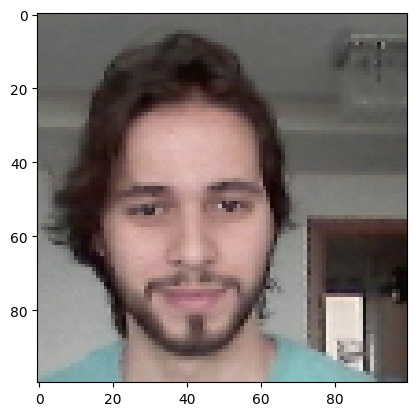

In [24]:

res = pre_process_twin(*example)
plt.imshow(res[1])

In [25]:
# Build data loader pipeline
data = data.map(pre_process_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [26]:
# Training partition
# Recovering 80% of the data for train
train_data = data.take(round(len(data)*.8))
# passing data as batches of 16 images
train_data = train_data.batch(16)
# starts pre-processing the next set of images to avoid bottleneck
train_data = train_data.prefetch(8)

In [27]:
# Testing partition
# skip the first X images (they were used to compose the train data)
test_data = data.skip(round(len(data)*.8))
test_data = test_data.take(round(len(data)*.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [28]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
# We have 16 images inside each example now
len(train_sample[0])

2022-12-01 19:28:04.264827: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-01 19:28:04.286034: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


16

# Part 4

### **4. Model Engineering**

![Siamese Neural Network](./siamese-neural-network.png)

### 4.1 Build Embedding Layer

In [29]:
def make_embedding(): 
    # We are going to work with 100x100px, so the numbers will not be exactly the same of the photo above, however it's not a problem.
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    # Flatting a 3-dimension into a one-dimension
    f1 = Flatten()(c4)
    # Fully connected layer
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [30]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

### 4.2 Build Distance Layer

In [31]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    # Anchor image will come with a positive ou negative image and we are going to compare similarity
    # calculating the absolute value of the diference of the two image representations
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [32]:
l1 = L1Dist()
l1

### 4.3 Make Siamese Model

In [33]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [34]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

## 5. Training

### 5.1 Setup Loss and Optimizer

In [35]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [36]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### 5.2 Estabilsh Checkpoints

In [37]:
#Creating directory
checkpoint_dir = os.path.join(APP_PATH , 'training_checkpoints')
if(not os.path.exists(checkpoint_dir)):
    print('Creating checkpoint directory')
    os.makedirs(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)
# To reload from the checkpoint you can use model.load('path_to_checkpoint'). This will load the pre trained weights into the existing model

### 5.3 Build Train Step Function

The basic flow for training on one batch is as follow:
1. Make a prediction
2. Calculate loss
3. Derive gradients
4. Calculate new weights and apply

In [38]:
# tf.function compiles a function into a callable TensorFlow graph
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        # Need to set training to True because certain layers only activate when is training
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### 5.4 Build Training Loop

In [39]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [40]:
# While the train_step function was focused on training for one batch, the loop here will be used to iterate over every batch in the dataset.
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

    date = str(datetime.now())[:19]
    # Save weights to load model and make pradictions without need to retrain
    siamese_model.save('siamese_model_' + date + '.h5')

### 5.5 Train the Model

In [41]:
# Define epochs to train
EPOCHS = 30
ALREADY_TRAINED = True

In [34]:
if not ALREADY_TRAINED: 
    train(train_data, EPOCHS)


 Epoch 1/30
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
40/40 [==============================] - 551s 14s/step
0.26163772 0.722561 0.8464286

 Epoch 2/30
40/40 [==============================] - 580s 15s/step
0.1375475 0.9141104 0.9802632

 Epoch 3/30
40/40 [==============================] - 514s 13s/step
0.084050596 0.95757574 0.9937107

 Epoch 4/30
40/40 [==============================] - 508s 13s/step
0.05413679 0.9611651 1.0

 Epoch 5/30
40/40 [==============================] - 508s 13s/step
0.039105516 0.95238096 0.99667776

 Epoch 6/30
40/40 [==============================] - 508s 13s/step
0.035145015 0.9939394 1.0

 Epoch 7/30
40/40 [==============================] - 509s 13s/step
0.06220647 0.9936508 1.0

 Epoch 8/30
40/40 [==============================] - 530s 13s/step
0.059501074 0.96941894 1.0

 Epoch 9/30
40/40 [==============================] - 553s 14s/step
0.08

# Part 6

## 6. Evaluate Model

### 6.1 Import Metrics

In [64]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### 6.2 Make Predictions

In [65]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [66]:
y_hat = siamese_model.predict([test_input, test_val])

In [67]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]

In [68]:
y_true

array([0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.],
      dtype=float32)

### 6.3 Calculate Metrics

#### 6.3.1 Calculating for one batch

In [69]:
# Creating a metric object 
# Recall shows what proportion of actual positives were identified correctly.
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.9

In [70]:
# Creating a metric object 
# Precision demonstrates what proportion of positive identifications were actually correct.
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.9

#### Calculating for all batchs

In [71]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

0.8625 0.97183096


### 6.4 Viz Results

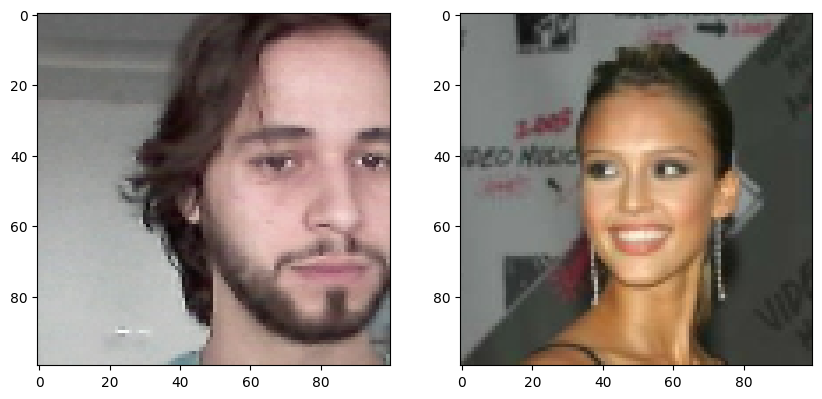

In [75]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

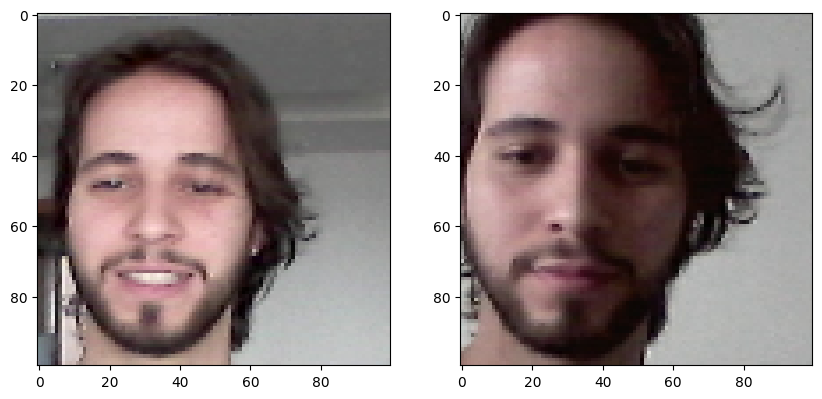

In [76]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

# Part 7

## 7. Save and Load Model

In [63]:
date = str(datetime.now())[:19]
# Save weights
# The train function already do the save.
# siamese_model.save('siamese_model_' + date + '.h5')

In [54]:
# Reload model
# Something cool, you can create different models and save them. Here you can choose the one that you want to work with.
siamese_model = tf.keras.models.load_model('siamese_model_400_30.h5', compile=False, 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [55]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[8.8488066e-01],
       [3.5723467e-06],
       [3.4811887e-07],
       [9.9920458e-01],
       [6.2828853e-08],
       [7.6203079e-08],
       [8.9617383e-01],
       [1.0697000e-09],
       [1.0569963e-06],
       [3.8468957e-01],
       [1.7482838e-01],
       [3.8488881e-07],
       [9.9511588e-01],
       [8.7897533e-06],
       [9.7063410e-01],
       [2.2235334e-01]], dtype=float32)

In [56]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# Part 8

## 8. Real Time Test

### 8.1 Verification Function

![Verification Explanation](verification-explanation.png)

Next steps:
1. create directory application_data
2. create directory application_data/verification_images
3. create directory application_data/input_image
4. Go to data, then positive samples, then and grap some images (50) and copy them to the verification_images

In [57]:
os.listdir(os.path.join('application_data', 'verification_images'))

['47de7408-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'e9a4fe94-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '44422b2d-6bef-11ed-886b-073aaa4b2cb1.jpg',
 '0806654f-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'f8e2a62b-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '8eafe1ca-6bee-11ed-886b-073aaa4b2cb1.jpg',
 'e393aa9f-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '6559047c-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'ecf7c458-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '61d7a79c-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'e0374b3a-6bee-11ed-886b-073aaa4b2cb1.jpg',
 'ebd9deb3-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '0593c042-6bef-11ed-886b-073aaa4b2cb1.jpg',
 '42e69ab2-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'd10aded3-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '0209dd6a-6bef-11ed-886b-073aaa4b2cb1.jpg',
 '0209dd6d-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'd23265e3-6bee-11ed-886b-073aaa4b2cb1.jpg',
 'fe4494ce-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '8d44770f-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '0806654d-6bef-11ed-886b-073aaa4b2cb1.jpg',
 '4ceab0ac-6bef-11ed-886b-073aaa4b2cb1.jpg',
 '247cfc62

In [77]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = pre_process(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = pre_process(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold

    print('Results:')
    print(len(results))
    print('Detection: ')
    print(detection)
    print('Verification: ')
    print(verification)
    print('Verified: ')
    print(verified)
    
    return results, verified

### 8.2 OpenCV Real Time Verification

In [78]:
# Increase thresholds to avoid false positives
# Detection Threshold: Metric above which a prediciton is considered positive 
# Verification Threshold: Proportion of positive predictions / total positive samples 
DETECTION_THRESHOLD = 0.8
VERIFICATION_THRESHOLD = 0.8


In [56]:
cap = cv2.VideoCapture(WEBCAM_DEVICE_NUMBER)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        # Run verification
        results, verified = verify(siamese_model, DETECTION_THRESHOLD, VERIFICATION_THRESHOLD)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Results:
50
Detection: 
49
Verification: 
0.98
Verified: 
True
True
Results:
50
Detection: 
50
Verification: 
1.0
Verified: 
True
True
Results:
50
Detection: 
50
Verification: 
1.0
Verified: 
True
True
Results:
50
Detection: 
50
Verification: 
1.0
Verified: 
True
True


In [56]:
results

[array([[0.9977186]], dtype=float32),
 array([[0.979723]], dtype=float32),
 array([[0.9998375]], dtype=float32),
 array([[0.46436992]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99287206]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99571085]], dtype=float32),
 array([[0.79686785]], dtype=float32),
 array([[0.98596525]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9776808]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99974227]], dtype=float32),
 array([[0.9997016]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9986577]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99987364]], dtype=float32),
 array([[0.08966964]], dtype=float32),
 array([[0.9921473]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99999917]], dtype=float32),
 array([[0.89544797]], dtype=float32),
 array([[0.98206806]], dtype=float32),
 array([[0.9807397]], dtype

In [58]:
40 / 50

0.8

## NEXT STEPS: Build the Facial Recognizer APP with Kivy